In [1]:
#!pip install clustergram pandas_profiling scipy sklearn statsmodels IPython dtale matplotlib rpy2 seaborn shap

In [2]:
#put in ~/.bashrc
#LD_PRELOAD="/mnt/distvol/R/4.1.2/lib64/R/lib/LibR.so"

In [3]:
#from fracdiff import fdiff
#import urbangrammar-graphics as ugg
%matplotlib inline
import os
from clustergram import Clustergram
from concurrent.futures import wait, ALL_COMPLETED
from dask.distributed import Client
from dask.distributed import as_completed
from dateutil.relativedelta import relativedelta
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from pandas import read_csv
from pandas_profiling import ProfileReport
#from rpy2.robjects import pandas2ri
from pmdarima.utils import diff_inv
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
from rpy2.rinterface_lib import openrlib
from scipy import stats
from scipy.cluster.vq import vq
from scipy.spatial.distance import cdist, pdist
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f
from sklearn import preprocessing
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import *
#from sklearn.preprocessing import PowerTransformer
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import scale
from sklearn.utils import as_float_array
from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm
import IPython
import concurrent.futures
import dask.dataframe as dd
import datetime
import dtale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg
import pmdarima
import pycorrelate
import random
import re
import rpy2
import rpy2.robjects as ro
import rpy2.situation
import scipy
import seaborn as sn
import shap
import sklearn
import sklearn.linear_model
import statsmodels.api as sm
import statsmodels.tools
import sys
import time
if not sys.warnoptions:
	import warnings
	warnings.simplefilter("ignore")


In [4]:
#c = get_config()
libpath = os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_LIBRARY_PATH'] = (
    rpy2.situation.r_ld_library_path_from_subprocess(openrlib.R_HOME) +
    libpath
)

In [5]:
def regress (dd_df):
    
    lr = LinearRegression()
    print("y needs to be named 'target', regress only uses the variable names, it doesn't use index's.  You apply that using .fit on this functions return")
    #dd_df = data_final
    variables=dd_df.columns
    target = variables[0]
    te = pd.DataFrame(dd_df['target']) 
    te.index = ([*dd_df.index])
    #te.columns = ['target']
    col_names = variables[~variables.isin(['target'])].ravel()

    s_f_s = sfs(lr, 
              k_features=np.int(len(col_names)*.05), 
              forward=True, 
              floating=True, 
              scoring='neg_mean_absolute_percentage_error',
              n_jobs=-1,
              cv=5)

    return (s_f_s)

def last_day_of_month(date):
    return date.replace(day=1) + relativedelta(months=1) - relativedelta(days=1)

def findknee(xdata):
    rate_of_change=(xdata[0]-xdata[-1])/(len(xdata)-1)
    #print(rate_of_change)
    delta = xdata-xdata[-1]
    deltas = []
    deltas.append(delta[0])
    for d in range(1,len(xdata)):
        deltas.append(deltas[d-1]-rate_of_change)
    #print(deltas)
    for d in range(0,len(xdata)):
        deltas[d]=delta[d]-deltas[d]
    return(np.abs(deltas))
    
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    power = PowerTransformer(method='yeo-johnson')
    power.lambdas_ = lambdas.values
    return(power.inverse_transform([data]))
    #return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.yeojohnson((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def inverse_yeo(og, data_, lambda_):
    values = []
    for i in range(0,len(og)):
        X = og[i]
        X_trans = data_[i]
        if X >= 0 and lambda_ == 0:
            X = exp(X_trans) - 1
        elif X >= 0 and lambda_ != 0:
            X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
        elif X < 0 and lambda_ != 2:
            X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
        elif X < 0 and lambda_ == 2:
            X = 1 - exp(-X_trans)
        
        values.append(X)
    return(pd.DataFrame(values))

def revert_yeo (og, data_, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data_.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data_.iloc[:,i]
        else:
            p#ower = PowerTransformer(method='yeo-johnson')
            #power.lambdas_ = lambdas.iloc[i].values
            #revert = pd.DataFrame(power.inverse_transform([data.iloc[:,i].values]))
            #return inv_boxcox(data, lambdas.values)
            revert = pd.DataFrame(inverse_yeo(og.iloc[:,i].values,data_.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data_.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data_.columns
    return reverted

class ZCA(BaseEstimator, TransformerMixin):
  def __init__(self, regularization=1e-5, copy=False):
      self.regularization = regularization
      self.copy = copy
  def fit(self, X, y=None):
      X = as_float_array(X, copy=self.copy)
      self.mean_ = np.mean(X, axis=0)
      X = X - self.mean_
      sigma = np.dot(X.T, X) / (X.shape[0] - 1)
      U, S, V = np.linalg.svd(sigma)
      tmp = np.dot(U, np.diag(1 / np.sqrt(S + self.regularization)))
      self.components_ = np.dot(tmp, U.T)
      return self
  def transform(self, X):
      X_transformed = X - self.mean_
      X_transformed = np.dot(X_transformed, self.components_.T)
      return X_transformed

def crosscorrelation(x, y, maxlag, mode='corr'):
    """
    Cross correlation with a maximum number of lags.

    `x` and `y` must be one-dimensional numpy arrays with the same length.

    This computes the same result as
        numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

    The return vaue has length 2*maxlag + 1.
    """
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = np.lib.stride_tricks.as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')
    if mode == 'dot':       # get lagged dot product
        return T.dot(px)
    elif mode == 'corr':    # gets Pearson correlation
        return (T.dot(px)/px.size - (T.mean(axis=1)*px.mean())) / \
               (np.std(T, axis=1) * np.std(px)) 
    
def ret_ccf(npa_):
    y_name = npa_[0]
    x_name = npa_[1]
    index = npa_[2]
    
    data = cleaned.loc[index].dropna()
    
    y = np.array(data.iloc[:,data.columns==y_name]).ravel()
    
    x = np.array(data.iloc[:,data.columns==x_name]).ravel()
    #print(x)
    #ccf = statsmodels.tsa.stattools.ccf(x,y)
    ccf = crosscorrelation(x,y, ccf_max_lag, mode='corr')
    #print(ccf)
    return([y_name,x_name,ccf])

def train(partition):
    est = LinearRegression()
    est.fit(partition[New_Names].values, partition['target'])
    return est

    
    '''
    
def nv_diff_sets(v_of_i,dataset,f_casts):

  s_=sndif_[which(colnames(raw)==var_of_int)]
  d_=ndif_[which(colnames(raw)==var_of_int)]
  
  startRow = c()
  for (r in rownames(dataset[1:d_,,drop=FALSE])):
    startRow = c(startRow,which(rownames(raw)==r))
  
  data_ = c(na.omit(c(dataset[,var_of_int], f_casts)))
  
  if(s_==0):
    inv_d = diffinv(data_,differences=d_,xi=raw[startRow,var_of_int])
  else:  
    inv_d = diffinv(diffinv(data_,differences = d_, xi=raw[startRow,var_of_int]), differences = s_,xi=raw[startRow:(startRow+season-1),var_of_int])
    
  return(inv_d)
'''

def lagpad(x, k):
    length=np.full(abs(k), np.NaN)
    #print(length)
    #k=k-1
    if (k>0):
        result = np.concatenate([length,x[0:(len(x)-k)]])
    elif (k<0):
        result= np.concatenate([(x[abs(k):(len(x))]),length])
    else:
        result= x
    return(result)

def lag(data):
    return lagpad(data,1)

def sndif_(npa_):
    index = npa_[2]
    #print(index)
    data = raw_int[npa_[0]].loc[index]
    #print(data)
    return(pmdarima.arima.nsdiffs(data.dropna(),m=npa_[1]))

def ndif_(npa_):
    index = npa_[1]
    data = raw_int[npa_[0]].loc[index]

    score = pmdarima.arima.ndiffs(data.dropna())
    
    if(score==0):
        score = 1
    return(score)

def clientFunction(function_name,npa):
    client = Client('192.168.3.100:8786',timeout=3)
    future = client.map(function_name,npa)

    results = []
    for f in as_completed(future):
        if(f.status=="error"):
            results.append("error")
        else:
            results.append(f.result())   

    client.close()

    return results

def restartClientFunction():
    client = Client('192.168.3.100:8786',timeout=3)
    client.restart()
    client.close()

def ts_cv_split (dataset):
    #rmse = []

    both_ = []
    #train_ = []
    #test_ = []
    for train_index, test_index in tscv.split(outer_dataset.index):
        #train_.append(train_index)
        #test_.append(test_index)
        both_.append([train_index,test_index])    
    return(both_)

def return_ts_cv_data (indexes):
    dataset=outer_dataset
    #print(indexes[0])
    return([dataset.iloc[indexes[0]],dataset.iloc[indexes[1]]])

def cv_pcor_check (npa_):
    
    #data = npa_
    n = npa_[2]
    New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])
    #print(npa_[0])
    
    #dataset= outer_dataset
    #train_index = npa_[0]
    #print(train_index)
    #test_index = npa_[1]
    
    #I don't need it to do training/test splits, but I had advanced ideas that would apply linear models to a test partition and go with the best error reduction... 
    # but partial correlations are just that except they don't take into consideration training/test partitions

    #target.iloc[training].iloc[train_index]
    subset_train = npa_[0]#dataset.iloc[train_index]
    train_index = subset_train.index
    subset_train = subset_train.dropna()
    subset_test = npa_[1]#dataset.iloc[test_index]
    #return(subset_test)
    test_index = subset_test.index
    subset_test = subset_test.dropna()
    
    y_reg_train_no_x = LinearRegression().fit(subset_train[New_Names_testing], subset_train['target'])
    y_fore_no_x = y_reg_train_no_x.predict(subset_test[New_Names_testing])
    y_resid_no_x = y_fore_no_x.ravel()-subset_test['target']
    
    x_reg_train_no_x = LinearRegression().fit(subset_train[New_Names_testing], subset_train[n])
    x_fore_no_x = x_reg_train_no_x.predict(subset_test[New_Names_testing])
    x_resid_no_x = x_fore_no_x.ravel()-subset_test[n]
    
    cor_resid = pd.concat([pd.DataFrame(y_resid_no_x),pd.DataFrame(x_resid_no_x)],axis=1).corr()
    #model_name = ols(formula_from_cols(subset, 'target'),data=data_final_dask_w_y[subset.columns].compute().iloc[train_index]).fit()
    #print(model_name.summary())

    #skip y and states
    #set_ = subset.loc[:, ~subset.columns.isin([target])].columns.tolist()
    
    c_value = np.array(cor_resid).ravel()[1]
    
    return(c_value)

#correlation p values
def pvalues(n):
    #n = New_Names[0]
    New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])

    p_values = pd.DataFrame()
    #inner_c_values = []

    #outer_dataset is derived from trainings
    indexes = ts_cv_split(outer_dataset)
    
    data = clientFunction(return_ts_cv_data,indexes)
    #print(data)
    #print(data)
    new_data = []
    
    for d in data:
        #print(d[0])
        #print(d[1])
        #print(n)
        new_data.append([d[0],d[1],n])
    #inner_c_values = []
    #print(new_data[0][0])
    #print(cv_pcor_check(new_data[0]))
    #here test against holdout data is done
    inner_c_values = clientFunction(cv_pcor_check,new_data)
    print(inner_c_values)
    #loops
    
    #for d in data:
        #inner_c_values.append(cv_pcor_check(d))

    n_ = len(indexes[1][0]) 

    dist = scipy.stats.beta(n_/2 - 1, n_/2 - 1, loc=-1, scale=2)
    p_value = 2*dist.cdf(-abs(np.mean(inner_c_values)))
    temp = pd.DataFrame([chosen,n,p_value]).T
    temp.columns = ['target','test','p']

    if(np.isnan(p_value)):
        #print(n)
        #print(inner_c_values)
        p_value = 0
    #p_values = pd.concat([p_values,temp],axis=0)
    return(p_value)

def y_subset(df):
    
    X = list ()
    
    for var_pos in range(0,len(df.columns)):
        variables=df.columns
        target=variables[var_pos]
        #print(target)
        #print(variables.isin([target]))
        temp = pd.concat([pd.DataFrame(df[target]),df.loc[:, ~df.columns.isin([target])]],axis=1)
        #print(temp)
        X.append(temp)
    return(X)

def undiff(data, seasonal, nonseasonal, xi):
    
    print("you have to know what xi for which use case you are going to use")
    
    #nonseasonal
    if(nonseasonal!=0 and seasonal==0):
        temp = np.concatenate([np.array(xi),np.array(data)])
        temp_ = diff_inv(temp,1,nonseasonal)
        return(temp_[-len(data):])
        
    #seasonal
    if(seasonal!=0 and nonseasonal == 0):
        temp = np.concatenate([np.array(xi),np.array(data)])
        temp_ = diff_inv(temp,season,1)
        return(temp_[-len(data):])
    
    #both
    if(seasonal==1 and nonseasonal == 1):
        #temp = data

        initial_seasonal_delta = xi.iloc[season]-xi.iloc[0]
        s_diffed_cat = np.concatenate([[np.array(initial_seasonal_delta)],np.array(data.dropna())])

        ns_undiffed = diff_inv(s_diffed_cat,1,1)[-len(temp_.dropna()):]

        ns_diffed_cat = np.concatenate([np.array(xi[1:(season+1)]),np.array(ns_undiffed)])
        s_undiffed = diff_inv(ns_diffed_cat,season,1)[-len(ns_undiffed):]

        return(s_undiffed[-len(data):])

    #non seasonal
    #undiff(temp_test['target'].dropna(), 0, nonseasonal,[raw_int[chosen].loc[temp_train['target'].index[-1]]])
    #test
    #undiff(temp_test[chosen],seasonal,nonseasonal,raw_int[chosen].loc[temp_train['target'].index[-1:]])
    #train
    #train_prior_date = raw_int[chosen].index[np.argwhere(data_final.index==temp_train['target'].index[0]).ravel()[0]-nonseasonal]
    #train_xi=[raw_int[chosen].loc[train_prior_date]]
    #undiff(temp_train['target'], seasonal, nonseasonal,xi)

    #seasonal
    #undiff(raw_int[chosen].diff(periods=4).dropna(),1,0,raw_int[chosen][0:season])

    #non seasonal and seasonal
    #undiff(raw_int[chosen].diff(periods=4).diff().dropna(),seasonal,nonseasonal,raw_int[chosen][0:season+nonseasonal])

def difference(data, seasonal, nonseasonal):

    if seasonal > 0:
        return(data.diff(periods=season).diff(nonseasonal))
    elif season > 0:
        return(data.diff(nonseasonal))
    else:
        return(data)
    

In [6]:
numCV = 5
tscv = TimeSeriesSplit(n_splits = 5)

In [7]:
raw = pd.read_csv("all_data.csv",index_col=0)
raw.index = pd.to_datetime(raw.index)

#fillna(method='bfill')
raw_int = raw.interpolate(method='time').dropna()


In [63]:
len(temp_test)
len(temp_train)

14

In [64]:
indexes = train_test_split(raw_int.index, test_size=.25, random_state=0, shuffle=False)

test_sets = []

for i in indexes:
    test_sets.append(raw_int.index.difference(i))
    
training = indexes[0]
testing = indexes[1]

In [65]:
training

DatetimeIndex(['2008-03-31', '2008-06-30', '2008-09-30', '2008-12-31',
               '2009-03-31', '2009-06-30', '2009-09-30', '2009-12-31',
               '2010-03-31', '2010-06-30', '2010-09-30', '2010-12-31',
               '2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [66]:
#delta = (raw_int-raw_int.shift()).dropna()
#raw_delta = (raw_int - raw_int.apply(lag,0)).dropna()
#raw_delta.head()

#raw_delta.isna().sum().sum()

In [67]:
testing

DatetimeIndex(['2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [68]:

#for i in range(0,len(raw_int.columns)):
        
#np.max(sndif)

In [69]:
#raw_int.diff().dropna().apply(pmdarima.arima.nsdiffs(m=4))

sndif = []

season = 4
maxn = season

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s],maxn,training])
    
sndif = clientFunction(sndif_,npa)    

In [70]:
#sndif_(npa[0])
#sndif

In [71]:
ndif = []

npa = []

for s in range(0,len(raw_int.columns)):
    npa.append([raw_int.columns[s],training])
    
ndif = clientFunction(ndif_,npa)           

In [72]:
#doesn't preserve na's...
#len(pmdarima.utils.diff(temp,1,1).ravel())

deseasoned = pd.DataFrame()
for i in range(0,len(raw_int.columns)):
    if(sndif[i]*season == 0):
        temp = raw_int.iloc[:,[i]]
    else:
        temp = raw_int.iloc[:,[i]]
        if(sndif[i]>0):
            for d in range(0,sndif[i]):
                temp = pd.DataFrame(temp.values.ravel()-lagpad(temp.values.ravel(),1*season)).set_index(temp.index)
                temp.columns = raw_int.iloc[:,[i]].columns
    deseasoned = pd.concat([deseasoned,temp],axis=1)


In [73]:
#for d in deseasoned.columns:
    #print(d)

In [74]:
deseasoned_differenced = pd.DataFrame()

for i in range(0,len(raw_int.columns)):
    temp_ = deseasoned.iloc[:,[i]]
    colnames = temp_.columns
    if ndif[i]>0:
        #print(ndif[i])
        for d in range(0,ndif[i]):
            #print(d)
            #
            #print(temp_.columns)
            #temp_ = pd.DataFrame(temp_.values.ravel()-lagpad(temp_.values.ravel(),1)).set_index(temp_.index)
            #temp_.columns = colnames
            temp = temp_.diff()
    temp.columns = temp_.columns
    deseasoned_differenced = pd.concat([deseasoned_differenced,temp],axis=1)


In [75]:
#for d in deseasoned_differenced.columns:
    #print(d)

In [76]:
deseasoned_differenced.interpolate(method='time').isna().sum().sum()
#.fillna(method='bfill')
#raw_int = raw.dropna()


369

In [77]:
deseasoned_differenced.describe()

,ASPUS,AWHAETP,BAA10Y,BACDINA066MNFRBNY,BACTSAMFRBDAL,BAMLC0A0CM,BAMLCC0A1AAATRIV,BAMLCC0A4BBBTRIV,BAMLH0A3HYC,BAMLHYH0A0HYM2TRIV,...,VZ,W5000FLT,WBA,WEAT,WMT,XDOC,XLB,XLC,XLI,XLP
count,50.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,50.000000,54.000000,54.000000,46.000000,54.000000
mean,1778.000000,0.004938,-0.021673,0.616049,0.730864,-0.029071,6.546679,10.861154,-0.092833,18.254586,...,1.777626,0.218162,0.744255,2.831459,0.744255,0.824150,1.222605,0.876687,0.793717,0.999061
std,14961.178198,0.080201,0.453094,16.642048,14.135217,0.540044,13.975538,18.474739,3.406872,37.436962,...,4.546572,2.977538,3.116071,6.093759,3.116071,5.503900,7.873159,2.604406,20.611307,8.605673
min,-35400.000000,-0.200000,-1.504410,-64.233333,-31.233333,-1.678937,-25.510096,-50.098550,-9.396154,-139.901796,...,-8.272926,-10.610158,-7.288573,-5.146033,-7.288573,-13.523993,-22.058186,-5.179459,-46.347300,-20.193453
25%,-8575.000000,-0.033333,-0.192754,-6.583333,-7.891667,-0.175614,-4.122416,-0.649419,-1.334322,2.758185,...,-0.751921,-1.655371,-0.720025,-0.261821,-0.720025,-2.081028,-2.655422,-0.928805,-8.872956,-4.389770
50%,3400.000000,0.000000,-0.033490,0.416667,0.083333,-0.053672,7.569685,12.211152,-0.194841,22.699687,...,1.689364,0.880039,0.618146,1.524660,0.618146,0.008430,2.650421,0.867217,-1.026267,2.432004
75%,12825.000000,0.033333,0.144554,6.008333,9.291667,0.078655,15.460935,20.345925,0.917954,34.930997,...,4.331338,2.143258,2.035942,3.837932,2.035942,3.527494,6.389959,2.541639,7.123399,5.977480
max,30500.000000,0.233333,2.237218,56.766667,48.966667,2.784677,42.598631,60.558266,17.539328,97.333375,...,16.379358,5.889132,11.005911,28.643387,11.005911,20.736461,18.043609,6.931687,60.152724,21.302764


In [78]:
#for d in deseasoned_differenced.columns:
    #print(d)

In [79]:
#https://machinelearningmastery.com/time-series-data-stationary-python/
cleaned = deseasoned_differenced.interpolate(method='time')#.dropna()


In [80]:
#plt.plot(cleaned.iloc[:,0])

<AxesSubplot:>

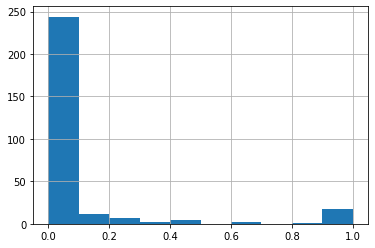

In [81]:
#How many are stationary?
%matplotlib inline
pd.DataFrame(cleaned.dropna().apply(adfuller).iloc[1,]).iloc[:,0].hist()

In [82]:
#for d in cleaned.columns:
    #print(d)

In [83]:
#np.cumsum(x_names=='BOGZ1FL105015105Q')

In [84]:
#len(cleaned.iloc[:,raw.columns=='BACDINA066MNFRBNY'])

In [85]:
#for c in cleaned.columns:
    #print(y_name)


In [86]:
ccf_max_lag = 4

ccf_ = []

npa = []

#chosen = cleaned.columns[random.randint(0,len(cleaned.columns)-1)]
chosen = 'MSPUS'
chosen = 'LXXRCSA'
print(chosen)
y_name = cleaned.columns[cleaned.columns==chosen].values[0]
#x_names = cleaned.columns[(cleaned.columns!=cleaned.columns[0])]
x_names = cleaned.columns

for s in range(0,len(cleaned.columns)):
    #y_name = y_name_
    x_name = x_names[s]
    #print(x_name)
    npa.append([y_name,x_name,training])
    
ccf_ = clientFunction(ret_ccf,npa)

y = np.array(cleaned.iloc[:,cleaned.columns==y_name]).ravel()
x = y
#last one is for comparing with itself to ensure 0 lag ccf is 1
ccf_.append([y_name,y_name,crosscorrelation(x,y, ccf_max_lag, mode='corr')])
#ccf_.append([np.array([y_name,y_name]).reshape(2,1),crosscorrelation(x,y, 4, mode='corr')])#


LXXRCSA


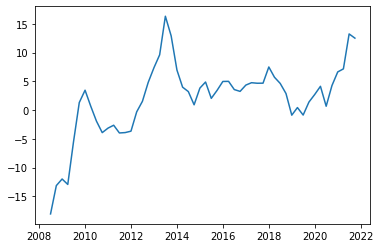

In [87]:
%matplotlib inline
plt.plot(cleaned[chosen])

In [88]:
range_ = [*range(-ccf_max_lag,ccf_max_lag+1)].copy()

ccf_scores = pd.DataFrame()

for c in ccf_:
    #print(c)
    y = c[0]
    x = c[1]
    #print(x)
    ar_ = pd.DataFrame(c[2])
    #print(ar_)
    ar_.index = range_
    ar_.columns = [x]
    #abs(ar_)
    ccf_scores = pd.concat([ccf_scores,ar_],axis=1)

In [89]:
#len(ccf_scores.columns)

In [90]:
#derive optimally lagged dataset

data_final = pd.DataFrame()

best_lags = []
#don't want the last one
for c in ccf_scores.columns[:-1]:
    #print(c)
    temp = ccf_scores[ccf_scores.index>0][c]
    bl = ccf_scores.index[ccf_scores.index>0][np.argmax(abs(temp))]
    best_lags.append(bl)
    data = pd.DataFrame(lagpad(cleaned[c],bl))
    data.index = cleaned[c].index
    data.columns = [c]
    data_final = pd.concat([data_final,data],axis=1)
    
#doesn't need to be shift, because all other values are offset by at least 1
temp = pd.DataFrame(cleaned[chosen])
temp.columns = ['target']
data_final = pd.concat([temp,data_final],axis=1)


In [91]:
#data_final_dask = dd.from_pandas(data_final,npartitions=128)
#data_final_dask_w_y = dd.concat([cleaned[[y_name]],data_final_dask.compute()],axis=1)
#names_ = ['target']
#names_.extend(cleaned.columns)
#data_final_dask_w_y.columns = names_

In [92]:
#data_final_dask.apply(np.cumsum,axis=1).compute()


In [93]:
#len(data_final.columns)

In [94]:
#plt.plot(raw_int[chosen])
#plt.plot(cleaned[chosen])
#plt.plot(data_final_dask_w_y[chosen].compute())
#plt.plot(data_final_dask_w_y[['target']].compute().loc[training])

In [95]:
#np.sort(data_final_dask_w_y.compute().isna().sum())

In [96]:
'''
zca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()
zca1 = zca.fit(zca1_subset)
zca1_df = pd.DataFrame(zca1.transform(zca1_subset))
zca1_df.columns = zca1_subset.columns
zca1_df.index = zca1_subset.index

zca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()
zca1 = zca.fit(zca1_subset)
zca1_df = pd.DataFrame(zca1.transform(zca1_subset))
zca1_df.columns = zca1_subset.columns
zca1_df.index = zca1_subset.index
#pd.concat([target,zca1],axis=1)
'''

"\nzca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()\nzca1 = zca.fit(zca1_subset)\nzca1_df = pd.DataFrame(zca1.transform(zca1_subset))\nzca1_df.columns = zca1_subset.columns\nzca1_df.index = zca1_subset.index\n\nzca1_subset = working_set[subset.columns.difference(['target',max_pname])].dropna()\nzca1 = zca.fit(zca1_subset)\nzca1_df = pd.DataFrame(zca1.transform(zca1_subset))\nzca1_df.columns = zca1_subset.columns\nzca1_df.index = zca1_subset.index\n#pd.concat([target,zca1],axis=1)\n"

In [97]:
#testing

In [98]:
#X = y_subset(subset)

In [99]:

#.compute().loc[training],training,testing
temp_train = data_final.loc[training].dropna()
temp_test = data_final.loc[testing].dropna()

drop = temp_train.columns[temp_train.apply(np.std)==0]

temp_train.drop(drop,axis=1,inplace=True)

s_f_s = regress(temp_train)

target = temp_train.columns[0]
#.fit is X, y format
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')

    fitted = s_f_s.fit(temp_train.loc[:, ~temp_train.columns.isin(['target'])], pd.DataFrame(temp_train['target']))

y needs to be named 'target', regress only uses the variable names, it doesn't use index's.  You apply that using .fit on this functions return


In [100]:
temp_train['target']


Date
2010-09-30    -3.918304
2010-12-31    -3.134260
2011-03-31    -2.632604
2011-06-30    -3.977183
2011-09-30    -3.909730
2011-12-31    -3.665519
2012-03-31    -0.306957
2012-06-30     1.522757
2012-09-30     4.809982
2012-12-31     7.378934
2013-03-31     9.603429
2013-06-30    16.310464
2013-09-30    12.896095
2013-12-31     6.958343
2014-03-31     3.981260
2014-06-30     3.215447
2014-09-30     0.918816
2014-12-31     3.824373
2015-03-31     4.878191
2015-06-30     2.038918
2015-09-30     3.422298
2015-12-31     4.974961
2016-03-31     4.994742
2016-06-30     3.565540
2016-09-30     3.249782
2016-12-31     4.346780
Name: target, dtype: float64

In [101]:
temp_test['target']

Date
2017-03-31     4.757675
2017-06-30     4.665787
2017-09-30     4.677645
2017-12-31     7.491525
2018-03-31     5.705483
2018-06-30     4.634503
2018-09-30     2.880017
2018-12-31    -0.883596
2019-03-31     0.437720
2019-06-30    -0.864640
2019-09-30     1.393387
2019-12-31     2.711928
2020-03-31     4.132691
2020-06-30     0.668652
2020-09-30     4.261507
2020-12-31     6.631403
2021-03-31     7.162005
2021-06-30    13.234862
2021-09-30    12.504175
Name: target, dtype: float64

In [102]:
import numpy as np

#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

In [103]:
f_test(temp_train['target'],temp_test['target'])
import scipy.stats as stats
stats.f_oneway(temp_train['target'],temp_test['target'])

F_onewayResult(statistic=1.0226548120930847, pvalue=0.31754690696094573)

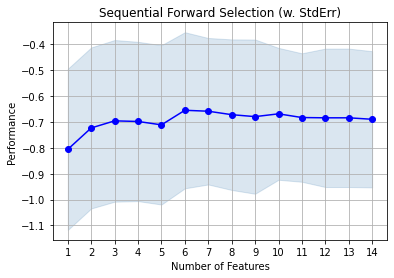

In [104]:

fig = plot_sfs(fitted.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.savefig(str(target)+'.png', dpi=300, format='png', bbox_inches='tight')
plt.grid()
plt.show()


In [105]:
metric_table = pd.DataFrame(fitted.get_metric_dict()).T

In [106]:
metric_table

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(172,)","[-2.0064296694822206, -0.6626591041963357, -0....",-0.80559,"(CUSR0000SEHA,)",0.800864,0.623099,0.31155
2,"(80, 172)","[-1.9595574638360589, -0.4401130437824479, -0....",-0.722785,"(TLT, CUSR0000SEHA)",0.800381,0.622724,0.311362
3,"(17, 80, 172)","[-1.9348033202829475, -0.37684863994931944, -0...",-0.695337,"(RECPROUSM156N, TLT, CUSR0000SEHA)",0.803501,0.625151,0.312576
4,"(17, 80, 126, 172)","[-1.9216810121655759, -0.3552099886479006, -0....",-0.697695,"(RECPROUSM156N, TLT, MPRIME, CUSR0000SEHA)",0.791726,0.61599,0.307995
5,"(17, 48, 80, 126, 172)","[-1.9349433079227654, -0.4869717178347933, -0....",-0.710844,"(RECPROUSM156N, DGORDER, TLT, MPRIME, CUSR0000...",0.791923,0.616143,0.308071
6,"(17, 48, 80, 126, 172, 285)","[-1.8611937544050463, -0.33899535618149546, -0...",-0.654453,"(RECPROUSM156N, DGORDER, TLT, MPRIME, CUSR0000...",0.775831,0.603623,0.301811
7,"(17, 48, 80, 100, 126, 172, 285)","[-1.7890212454982954, -0.4209113874347305, -0....",-0.658088,"(RECPROUSM156N, DGORDER, TLT, IPAXU, MPRIME, C...",0.728076,0.566468,0.283234
8,"(17, 48, 80, 100, 126, 172, 215, 285)","[-1.8062594205198852, -0.6066370129165483, -0....",-0.671454,"(RECPROUSM156N, DGORDER, TLT, IPAXU, MPRIME, C...",0.748428,0.582302,0.291151
9,"(17, 28, 48, 80, 100, 172, 215, 285, 288)","[-1.8310731871373254, -0.5044815456700475, -0....",-0.678999,"(RECPROUSM156N, FGCCSAQ027S, DGORDER, TLT, IPA...",0.76661,0.596449,0.298224
10,"(17, 19, 28, 68, 100, 160, 172, 178, 205, 285)","[-1.6857909216084206, -0.4630368319207633, -0....",-0.668183,"(RECPROUSM156N, UMCSENT, FGCCSAQ027S, VXVCLS, ...",0.655522,0.510018,0.255009


In [107]:
winners = metric_table[metric_table['avg_score']<(np.std(metric_table['avg_score'])+np.min(metric_table['avg_score']))].tail(1)['feature_names'].index
winners_ = np.asarray(fitted.get_metric_dict()[winners[0]]['feature_names'])

knee_last = np.min(np.where(np.round([*metric_table['avg_score']],6)==np.round(np.max([*metric_table['avg_score']]),6)))

#elbow method beats the other method
temp_df = findknee(np.array(metric_table['avg_score'][0:(knee_last+1)]))
winners_ = np.asarray(metric_table.iloc[np.min(np.where([temp_df==np.max(temp_df)])[1])]['feature_names'])
#winners_ = np.asarray(metric_table.iloc[10]['feature_names'])

In [108]:
winners_

array(['TLT', 'CUSR0000SEHA'], dtype='<U12')

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(172,)","[-2.0064296694822206, -0.6626591041963357, -0....",-0.80559,"(CUSR0000SEHA,)",0.800864,0.623099,0.31155
2,"(80, 172)","[-1.9595574638360589, -0.4401130437824479, -0....",-0.722785,"(TLT, CUSR0000SEHA)",0.800381,0.622724,0.311362
3,"(17, 80, 172)","[-1.9348033202829475, -0.37684863994931944, -0...",-0.695337,"(RECPROUSM156N, TLT, CUSR0000SEHA)",0.803501,0.625151,0.312576
4,"(17, 80, 126, 172)","[-1.9216810121655759, -0.3552099886479006, -0....",-0.697695,"(RECPROUSM156N, TLT, MPRIME, CUSR0000SEHA)",0.791726,0.61599,0.307995
5,"(17, 48, 80, 126, 172)","[-1.9349433079227654, -0.4869717178347933, -0....",-0.710844,"(RECPROUSM156N, DGORDER, TLT, MPRIME, CUSR0000...",0.791923,0.616143,0.308071
6,"(17, 48, 80, 126, 172, 285)","[-1.8611937544050463, -0.33899535618149546, -0...",-0.654453,"(RECPROUSM156N, DGORDER, TLT, MPRIME, CUSR0000...",0.775831,0.603623,0.301811
7,"(17, 48, 80, 100, 126, 172, 285)","[-1.7890212454982954, -0.4209113874347305, -0....",-0.658088,"(RECPROUSM156N, DGORDER, TLT, IPAXU, MPRIME, C...",0.728076,0.566468,0.283234
8,"(17, 48, 80, 100, 126, 172, 215, 285)","[-1.8062594205198852, -0.6066370129165483, -0....",-0.671454,"(RECPROUSM156N, DGORDER, TLT, IPAXU, MPRIME, C...",0.748428,0.582302,0.291151
9,"(17, 28, 48, 80, 100, 172, 215, 285, 288)","[-1.8310731871373254, -0.5044815456700475, -0....",-0.678999,"(RECPROUSM156N, FGCCSAQ027S, DGORDER, TLT, IPA...",0.76661,0.596449,0.298224
10,"(17, 19, 28, 68, 100, 160, 172, 178, 205, 285)","[-1.6857909216084206, -0.4630368319207633, -0....",-0.668183,"(RECPROUSM156N, UMCSENT, FGCCSAQ027S, VXVCLS, ...",0.655522,0.510018,0.255009


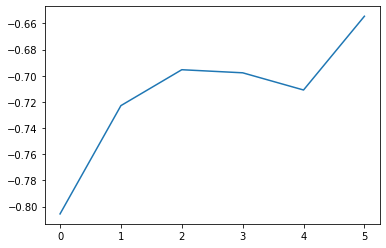

In [109]:
plt.plot(np.array(metric_table['avg_score'][0:(knee_last+1)]))

metric_table.loc[metric_table['avg_score']<=np.std(abs(metric_table['avg_score'][0:(knee_last+1)]))+np.min(abs(metric_table['avg_score'][0:(knee_last+1)]))+np.min((metric_table['avg_score'][0:(knee_last+1)]))]

In [110]:
X_train = temp_train[winners_]

y_train = temp_train['target']

sig_table = np.zeros(shape=(len(X_train.columns)))
signs_table = np.zeros(shape=(len(X_train.columns)))
kfold = KFold(n_splits=numCV, shuffle=True)

#used for pcorr kfolds as well as best subsets
train_ = []
test_ = []

kfold.get_n_splits(X_train.index)

for train_indices, test_indices in kfold.split(X_train.index):
    train_.append(train_indices)
    test_.append(test_indices)
    


In [111]:
threshold = .05

set_ = list(winners_)

max_pvalue = 1

subset = temp_train[np.concatenate([['target'],winners_])]

n=len(subset)

while(max_pvalue>=threshold):

    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    p_values = pd.DataFrame(2*dist.cdf(-abs(subset.pcorr()['target']))).T
    p_values.columns = list(subset.columns)

    max_pname = p_values.idxmax(axis=1)[0]
    max_pvalue = p_values[max_pname].values[0]

    print(max_pvalue, max_pname)

    #to prevent errors, always return 1
    if len(set_)==1:
        break

    if (max_pvalue > threshold):

        set_.remove(max_pname)
        temp = [target]
        temp.extend(set_)
        subset = subset[temp]

        max_pname=""

0.2366458196790205 TLT
0.0701319103228923 CUSR0000SEHA


In [112]:
set_

['CUSR0000SEHA']

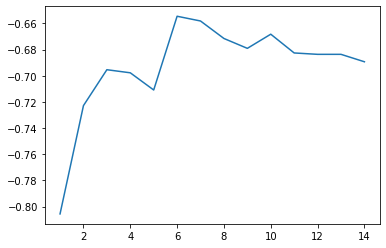

In [113]:
plt.plot(metric_table['avg_score'])

In [114]:
temp_train[np.concatenate([['target'],set_])]

,target,CUSR0000SEHA
Date,,
2010-09-30,-3.918304,-0.802000
2010-12-31,-3.134260,0.190333
2011-03-31,-2.632604,1.191667
2011-06-30,-3.977183,1.397333
2011-09-30,-3.909730,0.715667
2011-12-31,-3.665519,1.242667
2012-03-31,-0.306957,1.343000
2012-06-30,1.522757,0.235333
2012-09-30,4.809982,0.565667


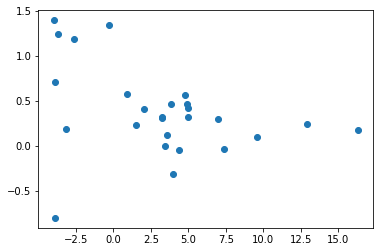

In [115]:
for w in set_:
    plt.scatter(temp_train[['target']], temp_train[[w]])
    plt.show()

In [116]:
#temp_train[list('target').extend(winners_)]


In [117]:
len(best_lags)

289

['TLT', 'CUSR0000SEHA']

KeyboardInterrupt: 

In [128]:
lagposition = []
lagatposition = []
for s in range(0,len(winners_)):
    lagposition.append(np.where(ccf_scores.columns==winners_[s])[0][0])
    lagatposition.append(best_lags[np.where(ccf_scores.columns==winners_[s])[0][0]])

In [129]:
lagatposition

[1, 1]

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     2.533
Date:                Fri, 07 Jan 2022   Prob (F-statistic):              0.101
Time:                        15:36:43   Log-Likelihood:                -76.116
No. Observations:                  26   AIC:                             158.2
Df Residuals:                      23   BIC:                             162.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.1370      1.299      3.956   

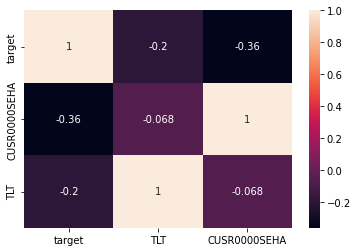

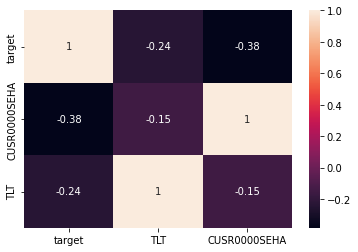

In [130]:
X = sm.add_constant(temp_train[winners_])
results = sm.OLS(temp_train['target'],X).fit()
print(results.summary())

inverses = []

print(chosen)

value = np.where(raw_int.columns==chosen)[0][0]

#print(
print('sndif:', sndif[value])
print('ndif:', ndif[value])
inverses.append([chosen,sndif[value],ndif[value]])

train_forecast = results.predict(temp_train[np.concatenate([['target'],winners_])])
test_forecast = results.predict(temp_test[np.concatenate([['target'],winners_])])

print(MAPE(temp_test['target'],test_forecast))

index_ = []

for w in winners_:
    print(w)
    value = np.where(raw_int.columns==w)[0][0]
    index_.append(value)
    inverses.append([w,sndif[value],ndif[value]])
    print('lags:', best_lags[np.where(ccf_scores.columns==winners_[s])[0][0]])
    print('sndif:', sndif[value])
    print('ndif:', ndif[value])

%matplotlib inline
corrMatrix = pd.concat([temp_train['target'],temp_train[winners_]],axis=1).corr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(corrMatrix, annot=True)
plt.show()

pcorrMatrix = pd.concat([temp_train['target'],temp_train[winners_]],axis=1).pcorr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(pcorrMatrix, annot=True)
plt.show()


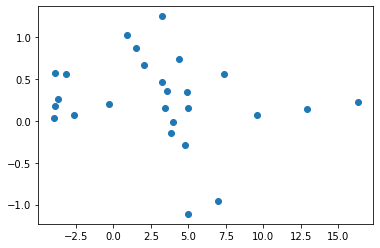

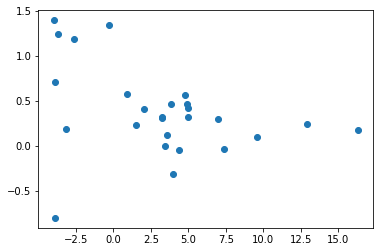

In [131]:
for w in winners_:
    plt.scatter(temp_train[['target']], temp_train[[w]])
    plt.show()

In [139]:
print(len(temp_train))
print(len(temp_test))

26
19


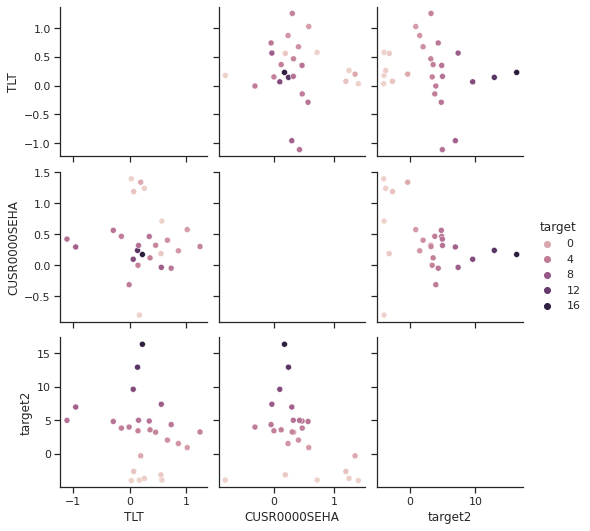

In [136]:
#for w in winners_:
sn.set_theme(style="ticks")

t = temp_train[np.concatenate([['target'],winners_])]
t_ = t[['target']]
t_.columns = ['target2']
#t_.rename('target2')
t = pd.concat([t,t_],axis=1)
sn.pairplot(t, hue="target")
    #plt.scatter(temp_train[['target']], temp_train[[w]])

In [ ]:
seasonal = inverses[0][1]
print(seasonal)
nonseasonal = inverses[0][2]
print(nonseasonal)


In [ ]:
'''
newindex = []

for i in range(0,len(temp_train.index)):
    newindex.append(temp_train.index[i])

for i in range(0,nonseasonal):
    newindex.append(last_day_of_month(temp_train.index[-1] + pd.DateOffset(90*i)))
    
len(newindex)


'''

In [ ]:
plt.plot(pd.concat([raw_int.loc[temp_train.index][[chosen]],pd.DataFrame(undiff(temp_train['target'], seasonal, nonseasonal, train_xi),columns=['target']).set_index(temp_train.index)],axis=1))

In [ ]:
train_prior_date = raw_int[chosen].index[np.argwhere(data_final.index==temp_train['target'].index[0]).ravel()[0]-nonseasonal]
train_xi=[raw_int[chosen].loc[train_prior_date]]

undiffed_train = pd.DataFrame(undiff(temp_train['target'], seasonal, nonseasonal, train_xi),columns=['target']).set_index(temp_train.index)
undiffed_train_forecast = pd.DataFrame(undiff(train_forecast, seasonal, nonseasonal, train_xi),columns=['target']).set_index(temp_train.index)

undiffed_test_forecast = pd.DataFrame(undiff(test_forecast, seasonal, nonseasonal,[raw_int[chosen].loc[temp_train['target'].index[-1]]]),columns=['target']).set_index(temp_test.index)
undiffed_test = pd.DataFrame(undiff(temp_test['target'].dropna(), 0, nonseasonal,[raw_int[chosen].loc[temp_train['target'].index[-1]]]),columns=['target']).set_index(temp_test.index)

In [ ]:
plt.plot(raw_int[chosen])
plt.show()
plt.plot(pd.concat([undiffed_train,undiffed_test],axis=0))
plt.plot(pd.concat([undiffed_train_forecast,undiffed_test_forecast],axis=0))

plt.show()
plt.plot(pd.concat([undiffed_train,undiffed_train_forecast],axis=1))
plt.plot(pd.concat([undiffed_test,undiffed_test_forecast],axis=1))

In [ ]:
import scipy.stats as stats
stats.f_oneway(a,b)

In [ ]:
temp_train['target']

In [ ]:
temp_test['target']

In [ ]:
X = sm.add_constant(data_final.dropna()[set_])
results = sm.OLS(data_final.dropna()[['target']],X).fit()
print(results.summary())

inverses = []

print(chosen)

value = np.where(raw_int.columns==chosen)[0][0]

#print(
print('sndif:', sndif[value])
print('ndif:', ndif[value])
inverses.append([chosen,sndif[value],ndif[value]])

train_forecast = results.predict(temp_train[np.concatenate([['target'],set_])])
test_forecast = results.predict(temp_test[np.concatenate([['target'],set_])])

print(MAPE(temp_test['target'],test_forecast))

index_ = []

for w in set_:
    print(w)
    value = np.where(raw_int.columns==w)[0][0]
    index_.append(value)
    inverses.append([w,sndif[value],ndif[value]])
    print('lags:', best_lags[np.where(ccf_scores.columns==set_[s])[0][0]])
    print('sndif:', sndif[value])
    print('ndif:', ndif[value])

%matplotlib inline
corrMatrix = pd.concat([temp_train['target'],temp_train[set_]],axis=1).corr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(corrMatrix, annot=True)
plt.show()

pcorrMatrix = pd.concat([temp_train['target'],temp_train[set_]],axis=1).pcorr().sort_values(kind="quicksort", by='target', ascending=False,key=abs)
sn.heatmap(pcorrMatrix, annot=True)
plt.show()


In [ ]:
'''


future = client.map(regress, X)

results = []
best = -1
for f in as_completed(future):
    results.append(f.result())
    
def y_subset(df):
    
    X = list ()
    
    for var_pos in range(0,len(df.columns)):
        variables=df.columns
        target=variables[var_pos]
        #print(target)
        #print(variables.isin([target]))
        temp = pd.concat([pd.DataFrame(df[target]),df_.loc[:, ~df.columns.isin([target])]],axis=1)
        #print(temp)
        X.append(temp)
    return(X)
    '''

In [ ]:
'''
scaler = StandardScaler()

tscv = TimeSeriesSplit(n_splits = 5)

#scaler.fit(np.array(data_final_dask_w_y[['target']].compute().loc[training]).reshape(-1, 1))

New_Names = list(data_final_dask_w_y.columns.difference(['target']))

outer_dataset = data_final_dask_w_y.compute().loc[training].dropna()
target = outer_dataset[['target']]

subset = pd.concat([target,outer_dataset[New_Names]],axis=1)

num_folds = 2
#kfold = KFold(n_splits=num_folds, shuffle=False)
#train, test = kfold.get_n_splits(outer_dataset.index)

p_threshold = .05

iteration = 0
max_pvalue = 1

while(max_pvalue>=.05):
#
    print(chosen)
    
    print(New_Names)
    
    n_p_values = pd.DataFrame()

    p_values = []
    
    #parallelize here (x16)
    for n in New_Names:
        #print(n)
        New_Names_testing = list(np.array(New_Names)[(np.array(New_Names)!=n)])
        p_values.append(pvalues(n))
        
    p_values_df = pd.DataFrame(p_values,index=New_Names)
    print(p_values_df)

    max_pname = New_Names[np.argmax(p_values_df)]
    max_pvalue = p_values[np.argmax(p_values_df)]

    #n_p_values = pd.concat([n_p_values,p_values],axis=0)
    #print(n_p_values)

    if (max_pvalue > .05):
        print([max_pname, max_pvalue])
        #New_Names.remove(max_pname)
        #New_Names_testing = list(np.array(New_Names_testing)[(np.array(New_Names_testing)!=max_pname)])
        New_Names = list(np.array(New_Names)[(np.array(New_Names)!=max_pname)])
        temp = ['target']
        temp.extend(New_Names)
        subset = subset[temp]
    print()
'''

In [ ]:
restartClientFunction()

In [ ]:
#data_temp = data_final_dask_w_y.compute()

In [ ]:
#subset[New_Names]

In [ ]:
'''
includes = []
for c in subset.columns:
    index = np.argwhere(data_final_dask_w_y.columns==c)[0][0]
    includes.append(index)
'''

In [ ]:
#reg = train(data_final_dask_w_y[subset.columns].compute().loc[training].dropna())
#subset.dropna()


In [ ]:
#reg = regress(data_final_dask_w_y[subset.columns].compute().dropna())

#### 